<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [2]:
import scikitplot as skplt
from sklearn.metrics import mean_squared_error
from lifelines.utils import concordance_index
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow_addons as tfa
from keras import backend as K
import tensorflow as tf

In [3]:
from tqdm.keras import TqdmCallback
from tqdm.auto import tqdm
from collections import defaultdict
import pandas as pd
import numpy as np

In [4]:
import mltle as mlt

Done.


In [6]:
SEED = 7

NUM_RES_BLOCKS = 1
GRAPH_DEPTH = 5
GRAPH_FEATURES = 'g78'
GRAPH_TYPE = 'gin_eps0'
NORMALIZE = False
NORMALIZATION_TYPE = ''
NUM_EPOCHS = 1000
DISCOUNT = 0.9
BATCH_SIZE = 1024

data_path = '../data/data_pEC50/'
data_type = 'pEC50'
model_name = f'Res1GIN5_{data_type}'

In [7]:
tf.keras.backend.clear_session()
np.random.seed(SEED)
tf.random.set_seed(SEED)

model = mlt.graph_training.GraphModel(protein_emb_size=64, protein_alphabet_len=8006)

order = ['pKi', 'pIC50', 'pKd', 'pEC50', 'is_active', 'qed', 'pH']
loss_weights = [1.0] * len(order)

variables = {}
for var in order:
    variables[var] = K.variable(0.0)

LossCallback = mlt.training_utils.LossWithMemoryCallback(
    variables, discount=DISCOUNT, decay=0.8)

uselosses = defaultdict(lambda: mlt.training_utils.mse_loss_wrapper)
uselosses['is_active'] = 'binary_crossentropy'
uselosses['qed'] = 'binary_crossentropy'

for k, v in variables.items():
    if k not in uselosses.keys():
        uselosses[k] = uselosses[k](v)

usemetrics = {data_type: [tf.keras.metrics.mse, mlt.training_utils.cindex_score]}

activations = defaultdict(lambda: 'linear')
activations['is_active'] = 'sigmoid'
activations['qed'] = 'sigmoid'

initializer = tf.keras.initializers.VarianceScaling(scale=1., mode='fan_in', distribution='normal', seed=SEED)
optimizer = tfa.optimizers.Lookahead(tf.keras.optimizers.Nadam(), sync_period=3)

model = model.create_model(order=order,
                           activations=activations,
                           activation='relu',
                           pooling_mode='max',
                           num_res_blocks=NUM_RES_BLOCKS,
                           units_per_head=64,
                           units_per_layer=1024,
                           dropout_rate=0.3,
                           protein_kernel=(7, 7),
                           loss_weights=loss_weights,
                           usemetrics=usemetrics,
                           uselosses=uselosses,
                           initializer=initializer,
                           optimizer=optimizer,
                           protein_strides_down=1,
                           graph_depth=GRAPH_DEPTH,
                           num_graph_features=78,
                           graph_type=GRAPH_TYPE)

2022-08-22 17:21:30.753253: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-22 17:21:30.753598: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-22 17:21:30.753809: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-22 17:21:30.753941: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Done. Total trainable params: 2290857


In [ ]:
tf.keras.utils.plot_model(model,
                          rankdir='LR',
                          show_shapes=True,
                          show_layer_activations=True,
                          dpi=96)

In [9]:
X_train = pd.read_csv(data_path + f"data_human_agg05_{data_type}_train.csv")[['smiles', 'target'] + order]
X_valid = pd.read_csv(data_path + f"data_human_agg05_{data_type}_valid.csv")[['smiles', 'target'] + order]
X_test = pd.read_csv(data_path + f"data_human_agg05_{data_type}_test.csv")[['smiles', 'target'] + order]
X_train.head(2)

,smiles,target,pKi,pIC50,pKd,pEC50,is_active,qed,pH
0,CCC(C)C(NC(=O)C(CC(C)C)NC(=O)C(NC(=O)C(N)CCSC)...,MSGTKLEDSPPCRNWSSASELNETQEPFLNPTDYDDEEFLRYLWRE...,NaN,NaN,NaN,8.886057,1.0,0.016357,NaN
1,O=C(O)c1cccc(-c2cccc(NCCNCC(O)c3cccc(Cl)c3)c2)c1,MGAGVLVLGASEPGNLSSAAPLPDGAATAARLLVPASPPASLLPPA...,NaN,NaN,NaN,5.399997,0.0,0.391956,NaN


In [10]:
mapseq = mlt.datamap.MapSeq(drug_mode=GRAPH_FEATURES,
                            protein_mode='protein_3',
                            max_drug_len=100,
                            max_protein_len=1000,
                            graph_normalize=NORMALIZE,
                            graph_normalization_type=NORMALIZATION_TYPE)

drug_seqs = np.hstack((X_train['smiles'].unique(), X_valid['smiles'].unique(), X_test['smiles'].unique()))
protein_seqs = np.hstack((X_train['target'].unique(), X_valid['target'].unique(), X_test['target'].unique()))

map_drug, map_protein = mapseq.create_maps(drug_seqs=drug_seqs,
                                           protein_seqs=protein_seqs)

  0%|          | 0/59305 [00:00<?, ?it/s]

  0%|          | 0/1395 [00:00<?, ?it/s]

In [11]:
batch_size = BATCH_SIZE

train_gen = mlt.datagen.DataGen(X_train, map_drug, map_protein, drug_graph_mode=True)
train_gen = train_gen.get_generator(batch_size)

valid_gen = mlt.datagen.DataGen(X_valid, map_drug, map_protein, drug_graph_mode=True, shuffle=False)
valid_gen = valid_gen.get_generator(batch_size)

In [12]:
steps_per_epoch = X_train.shape[0] // batch_size
valid_steps = X_valid.shape[0] // batch_size

In [13]:
best_model_path = f"Best_{model_name}.h5"
CheckPointCallback = tf.keras.callbacks.ModelCheckpoint(best_model_path,
                                                        monitor=f'val_{data_type}_mean_squared_error',
                                                        verbose=1,
                                                        save_best_only=True,
                                                        mode='auto',
                                                        save_weights_only=True)

CSVLoggerCallback = tf.keras.callbacks.CSVLogger(f"{model_name}.log")

In [14]:
history = model.fit(train_gen,
                    validation_data=valid_gen,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=valid_steps,
                    verbose=0,
                    callbacks=[TqdmCallback(), CheckPointCallback,
                               LossCallback, CSVLoggerCallback],
                    epochs=NUM_EPOCHS)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

2022-08-22 17:23:26.365692: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-08-22 17:23:26.729355: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-08-22 17:23:27.671086: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-22 17:23:27.671362: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-22 17:23:27.671379: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-08-22 17:23:27.671628: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-22 17:23:27.671660: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to


Epoch 1: val_pEC50_mean_squared_error improved from inf to 35.93507, saving model to Best_Res1GIN5_pEC50.h5

Epoch 2: val_pEC50_mean_squared_error improved from 35.93507 to 29.06479, saving model to Best_Res1GIN5_pEC50.h5

Epoch 3: val_pEC50_mean_squared_error improved from 29.06479 to 21.15209, saving model to Best_Res1GIN5_pEC50.h5

Epoch 4: val_pEC50_mean_squared_error improved from 21.15209 to 16.68833, saving model to Best_Res1GIN5_pEC50.h5

Epoch 5: val_pEC50_mean_squared_error improved from 16.68833 to 11.00428, saving model to Best_Res1GIN5_pEC50.h5

Epoch 6: val_pEC50_mean_squared_error did not improve from 11.00428

Epoch 7: val_pEC50_mean_squared_error improved from 11.00428 to 9.61170, saving model to Best_Res1GIN5_pEC50.h5

Epoch 8: val_pEC50_mean_squared_error improved from 9.61170 to 7.40237, saving model to Best_Res1GIN5_pEC50.h5

Epoch 9: val_pEC50_mean_squared_error improved from 7.40237 to 6.37389, saving model to Best_Res1GIN5_pEC50.h5

Epoch 10: val_pEC50_mean_squ


Epoch 106: val_pEC50_mean_squared_error did not improve from 0.73386

Epoch 107: val_pEC50_mean_squared_error did not improve from 0.73386

Epoch 108: val_pEC50_mean_squared_error did not improve from 0.73386

Epoch 109: val_pEC50_mean_squared_error did not improve from 0.73386

Epoch 110: val_pEC50_mean_squared_error did not improve from 0.73386

Epoch 111: val_pEC50_mean_squared_error did not improve from 0.73386

Epoch 112: val_pEC50_mean_squared_error did not improve from 0.73386

Epoch 113: val_pEC50_mean_squared_error did not improve from 0.73386

Epoch 114: val_pEC50_mean_squared_error did not improve from 0.73386

Epoch 115: val_pEC50_mean_squared_error did not improve from 0.73386

Epoch 116: val_pEC50_mean_squared_error did not improve from 0.73386

Epoch 117: val_pEC50_mean_squared_error did not improve from 0.73386

Epoch 118: val_pEC50_mean_squared_error did not improve from 0.73386

Epoch 119: val_pEC50_mean_squared_error improved from 0.73386 to 0.70428, saving model to


Epoch 220: val_pEC50_mean_squared_error did not improve from 0.66305

Epoch 221: val_pEC50_mean_squared_error did not improve from 0.66305

Epoch 222: val_pEC50_mean_squared_error did not improve from 0.66305

Epoch 223: val_pEC50_mean_squared_error did not improve from 0.66305

Epoch 224: val_pEC50_mean_squared_error did not improve from 0.66305

Epoch 225: val_pEC50_mean_squared_error did not improve from 0.66305

Epoch 226: val_pEC50_mean_squared_error did not improve from 0.66305

Epoch 227: val_pEC50_mean_squared_error did not improve from 0.66305

Epoch 228: val_pEC50_mean_squared_error did not improve from 0.66305

Epoch 229: val_pEC50_mean_squared_error did not improve from 0.66305

Epoch 230: val_pEC50_mean_squared_error did not improve from 0.66305

Epoch 231: val_pEC50_mean_squared_error did not improve from 0.66305

Epoch 232: val_pEC50_mean_squared_error did not improve from 0.66305

Epoch 233: val_pEC50_mean_squared_error did not improve from 0.66305

Epoch 234: val_pEC5


Epoch 336: val_pEC50_mean_squared_error did not improve from 0.64840

Epoch 337: val_pEC50_mean_squared_error did not improve from 0.64840

Epoch 338: val_pEC50_mean_squared_error did not improve from 0.64840

Epoch 339: val_pEC50_mean_squared_error did not improve from 0.64840

Epoch 340: val_pEC50_mean_squared_error did not improve from 0.64840

Epoch 341: val_pEC50_mean_squared_error did not improve from 0.64840

Epoch 342: val_pEC50_mean_squared_error did not improve from 0.64840

Epoch 343: val_pEC50_mean_squared_error did not improve from 0.64840

Epoch 344: val_pEC50_mean_squared_error did not improve from 0.64840

Epoch 345: val_pEC50_mean_squared_error did not improve from 0.64840

Epoch 346: val_pEC50_mean_squared_error did not improve from 0.64840

Epoch 347: val_pEC50_mean_squared_error did not improve from 0.64840

Epoch 348: val_pEC50_mean_squared_error did not improve from 0.64840

Epoch 349: val_pEC50_mean_squared_error did not improve from 0.64840

Epoch 350: val_pEC5


Epoch 453: val_pEC50_mean_squared_error did not improve from 0.62434

Epoch 454: val_pEC50_mean_squared_error did not improve from 0.62434

Epoch 455: val_pEC50_mean_squared_error did not improve from 0.62434

Epoch 456: val_pEC50_mean_squared_error did not improve from 0.62434

Epoch 457: val_pEC50_mean_squared_error did not improve from 0.62434

Epoch 458: val_pEC50_mean_squared_error did not improve from 0.62434

Epoch 459: val_pEC50_mean_squared_error did not improve from 0.62434

Epoch 460: val_pEC50_mean_squared_error did not improve from 0.62434

Epoch 461: val_pEC50_mean_squared_error did not improve from 0.62434

Epoch 462: val_pEC50_mean_squared_error did not improve from 0.62434

Epoch 463: val_pEC50_mean_squared_error did not improve from 0.62434

Epoch 464: val_pEC50_mean_squared_error did not improve from 0.62434

Epoch 465: val_pEC50_mean_squared_error did not improve from 0.62434

Epoch 466: val_pEC50_mean_squared_error did not improve from 0.62434

Epoch 467: val_pEC5


Epoch 571: val_pEC50_mean_squared_error did not improve from 0.62434

Epoch 572: val_pEC50_mean_squared_error did not improve from 0.62434

Epoch 573: val_pEC50_mean_squared_error did not improve from 0.62434

Epoch 574: val_pEC50_mean_squared_error did not improve from 0.62434

Epoch 575: val_pEC50_mean_squared_error did not improve from 0.62434

Epoch 576: val_pEC50_mean_squared_error did not improve from 0.62434

Epoch 577: val_pEC50_mean_squared_error did not improve from 0.62434

Epoch 578: val_pEC50_mean_squared_error did not improve from 0.62434

Epoch 579: val_pEC50_mean_squared_error did not improve from 0.62434

Epoch 580: val_pEC50_mean_squared_error did not improve from 0.62434

Epoch 581: val_pEC50_mean_squared_error did not improve from 0.62434

Epoch 582: val_pEC50_mean_squared_error did not improve from 0.62434

Epoch 583: val_pEC50_mean_squared_error did not improve from 0.62434

Epoch 584: val_pEC50_mean_squared_error did not improve from 0.62434

Epoch 585: val_pEC5


Epoch 689: val_pEC50_mean_squared_error did not improve from 0.62434

Epoch 690: val_pEC50_mean_squared_error did not improve from 0.62434

Epoch 691: val_pEC50_mean_squared_error did not improve from 0.62434

Epoch 692: val_pEC50_mean_squared_error did not improve from 0.62434

Epoch 693: val_pEC50_mean_squared_error did not improve from 0.62434

Epoch 694: val_pEC50_mean_squared_error did not improve from 0.62434

Epoch 695: val_pEC50_mean_squared_error did not improve from 0.62434

Epoch 696: val_pEC50_mean_squared_error did not improve from 0.62434

Epoch 697: val_pEC50_mean_squared_error did not improve from 0.62434

Epoch 698: val_pEC50_mean_squared_error did not improve from 0.62434

Epoch 699: val_pEC50_mean_squared_error did not improve from 0.62434

Epoch 700: val_pEC50_mean_squared_error did not improve from 0.62434

Epoch 701: val_pEC50_mean_squared_error did not improve from 0.62434

Epoch 702: val_pEC50_mean_squared_error did not improve from 0.62434

Epoch 703: val_pEC5


Epoch 807: val_pEC50_mean_squared_error did not improve from 0.62434

Epoch 808: val_pEC50_mean_squared_error did not improve from 0.62434

Epoch 809: val_pEC50_mean_squared_error did not improve from 0.62434

Epoch 810: val_pEC50_mean_squared_error did not improve from 0.62434

Epoch 811: val_pEC50_mean_squared_error did not improve from 0.62434

Epoch 812: val_pEC50_mean_squared_error did not improve from 0.62434

Epoch 813: val_pEC50_mean_squared_error did not improve from 0.62434

Epoch 814: val_pEC50_mean_squared_error did not improve from 0.62434

Epoch 815: val_pEC50_mean_squared_error did not improve from 0.62434

Epoch 816: val_pEC50_mean_squared_error did not improve from 0.62434

Epoch 817: val_pEC50_mean_squared_error did not improve from 0.62434

Epoch 818: val_pEC50_mean_squared_error did not improve from 0.62434

Epoch 819: val_pEC50_mean_squared_error did not improve from 0.62434

Epoch 820: val_pEC50_mean_squared_error did not improve from 0.62434

Epoch 821: val_pEC5


Epoch 925: val_pEC50_mean_squared_error did not improve from 0.62434

Epoch 926: val_pEC50_mean_squared_error did not improve from 0.62434

Epoch 927: val_pEC50_mean_squared_error did not improve from 0.62434

Epoch 928: val_pEC50_mean_squared_error did not improve from 0.62434

Epoch 929: val_pEC50_mean_squared_error did not improve from 0.62434

Epoch 930: val_pEC50_mean_squared_error did not improve from 0.62434

Epoch 931: val_pEC50_mean_squared_error did not improve from 0.62434

Epoch 932: val_pEC50_mean_squared_error did not improve from 0.62434

Epoch 933: val_pEC50_mean_squared_error did not improve from 0.62434

Epoch 934: val_pEC50_mean_squared_error did not improve from 0.62434

Epoch 935: val_pEC50_mean_squared_error did not improve from 0.62434

Epoch 936: val_pEC50_mean_squared_error did not improve from 0.62434

Epoch 937: val_pEC50_mean_squared_error did not improve from 0.62434

Epoch 938: val_pEC50_mean_squared_error did not improve from 0.62434

Epoch 939: val_pEC5

In [15]:
[f"{k} : {float(v)}" for k, v in variables.items()]

['pKi : 0.0',
 'pIC50 : 0.0',
 'pKd : 0.0',
 'pEC50 : 0.0',
 'is_active : 0.0',
 'qed : 0.0',
 'pH : 0.0']

In [16]:
model.load_weights(best_model_path)
model.compile()
model.save(f"{model_name}.hdf5")

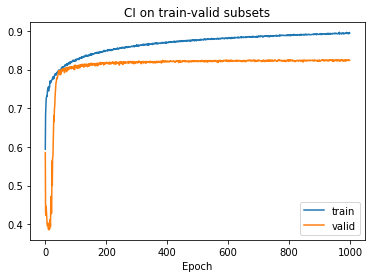

In [17]:
plt.plot(history.history[f'{data_type}_cindex_score'], label='train')
plt.plot(history.history[f'val_{data_type}_cindex_score'], label='valid')
plt.xlabel('Epoch')
plt.title('CI on train-valid subsets')
plt.legend()

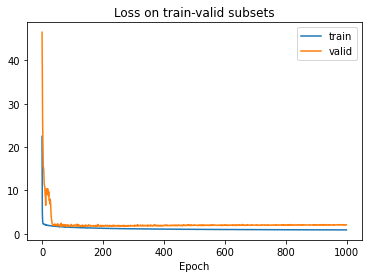

In [18]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.xlabel('Epoch')
plt.title('Loss on train-valid subsets')
plt.legend()

In [19]:
test_batch_size = mlt.training_utils.get_batch_size(X_test.shape[0])
test_batch_size

5

In [20]:
test_gen = mlt.datagen.DataGen(X_test,
                               map_drug,
                               map_protein,
                               shuffle=False,
                               test_only=True, 
                               drug_graph_mode=True)

test_gen = test_gen.get_generator(test_batch_size)

In [21]:
prediction = model.predict(test_gen,
                           steps=X_test.shape[0] // test_batch_size,
                           verbose=1)

4231/4231 [==============================] - 22s 5ms/step


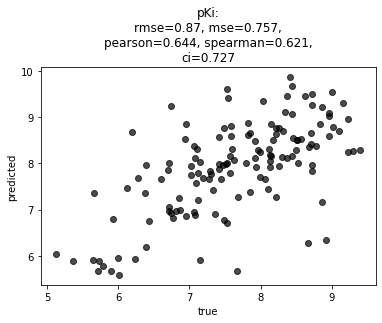

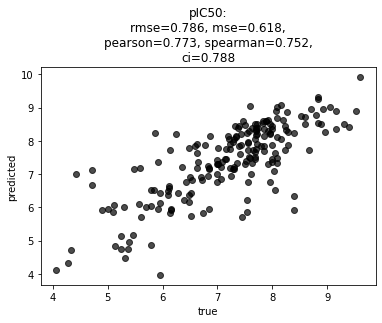

Empty set test set for: pKd, values sum = 0.0
or zero concordand pairs for the set of length 1, length of values set = 0


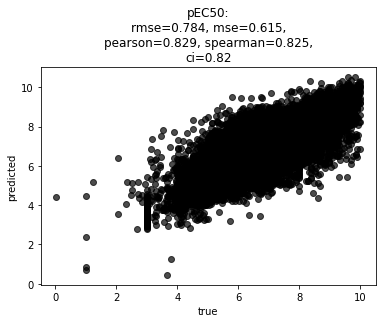

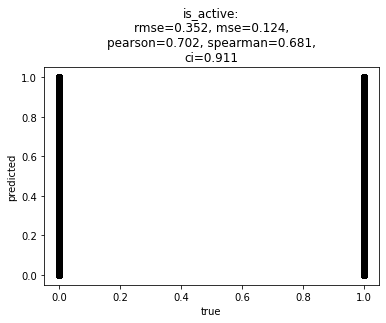

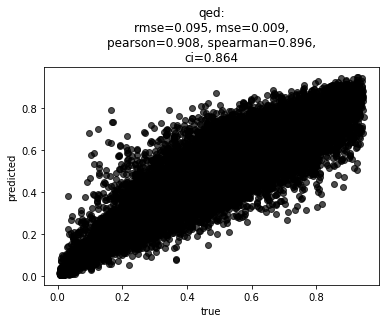

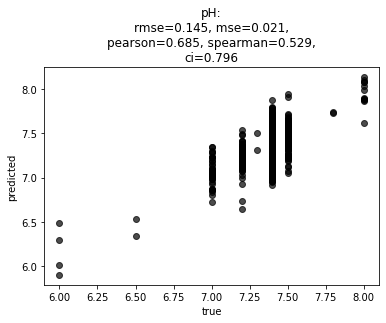

In [22]:
for k, col in enumerate(order):
    try:
        plt.scatter(X_test[col], prediction[k], alpha=0.7, c='k')
        plt.xlabel('true')
        plt.ylabel('predicted')
        y_true = X_test[col][X_test[col].notna()]
        y_pred = prediction[k][X_test[col].notna()].ravel()
        plt.title(col + ":\n" + mlt.training_utils.get_scores(y_true, y_pred))
        plt.show()
    except (ValueError, ZeroDivisionError) as e:
        print(f'Empty set test set for: {col}, values sum = {X_test[col].sum()}')
        print(f'or zero concordand pairs for the set of length 1, length of values set = {X_test[col].notna().sum()}')

In [23]:
P = prediction[order.index(data_type)].ravel().tolist()
G = X_test[data_type].values.tolist()

In [24]:
with open(f'test_{data_type}_{model_name}.csv', 'w', encoding='utf-8') as f:
    f.write('true, pred\n')
    for g, p in zip(G, P):
        f.write(f"{g},{p}\n")